Задача Segmentation. U-Net Architecture. </center>


# Задача сегментации в Semantic Segmentation
__Сементическая Сегментация__

* В __semantic segmentation__ - все объекты одного и того же типа классифицированны (сегментированны) меткой одного и того же класса. То есть, суть в том, что если мы проводим семантическую сегментацию, то мы решаем такую задачу классификации каждого пискселя из картинки на наше множество классов (Все люди относятся к классу люди и поэтому весь класс рамечен одним цветом).
* В __instance segmentation__ - все объекты на изображении имеют свою отдельную метку класса.





### Реализуем семантическую сегментацию с нуля при помощи архитектуры U-net:

In [ ]:
%%capture
!pip install torch_snippets

In [ ]:
import torch.cuda
from torch_snippets import *
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Определим функцию которая будет отвечать за трансформацию и аугментацию (пока нормализацию) датасета
transforms_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Теперь нам необходимо определить и расписать класс датасета, который мы будем использовать для того, чтобы решить задачу сегментации

class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'/content/drive/MyDrive/segment/images_prepped_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        """
        В данном методе мы будем ресайзить как картинку (наш инпут) так и маску (аутпут) для того
        чтобы они имели одинаковую размерность и наша архитектура была способно обработать 2 изображения
        одновременно без ошибок.
        Маска содержит целочисленные значения которые лежат в промежутке от 0 до 11 (то есть у нас всего 12 потенциальных классов
        в размеченной маске).
        """
        image = read(f'/content/drive/MyDrive/segment/images_prepped_{self.split}/{self.items[ix]}.jpg', 1)
        image = cv2.resize(image, (224, 224))
        mask = read(f'/content/drive/MyDrive/segment/annotations_prepped_{self.split}/{self.items[ix]}.tif')
        mask = cv2.resize(mask, (224, 224))
        return image, mask

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        """
        Метод который обрабатывает наш батч (читает маску и картинку, преваращет в тензор, нормализирует изображение (не маску!!!!) и отправляет на указанный девайс.
        """
        ims, masks = list(zip(*batch))
        ims = torch.cat([transforms_imgs(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks


In [ ]:
# Определяем тестовый и тренировочный датасеты и аналогично даталоудеры:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [ ]:
class SegDataTest(Dataset):
    def __init__(self, split):
        self.items = stems(f'/content/drive/MyDrive/segment/images_prepped_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'/content/drive/MyDrive/segment/images_prepped_TEST/BloodImage_00108.jpg',1)
        image = cv2.resize(image, (224, 224))
        mask = read(f'/content/drive/MyDrive/segment/annotations_prepped_TEST/BloodImage_00108.tif')
        mask = cv2.resize(mask, (224, 224))
        # return image
        return image, mask

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        """
        Метод который обрабатывает наш батч (читает маску и картинку, преваращет в тензор, нормализирует изображение (не маску!!!!) и отправляет на указанный девайс.
        """
        ims, masks = list(zip(*batch))
        # ims = list(zip(*batch))
        ims = torch.cat([transforms_imgs(im.copy()/255.)[None] for im in ims]).float().to(device)
        # ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims

In [ ]:
TEST_ds = SegDataTest('TEST')
TEST_dl = DataLoader(TEST_ds, batch_size=1,collate_fn=TEST_ds.collate_fn)
im = next(iter(TEST_dl))

In [ ]:
model = torch.load('/content/segmentation_model.pth')

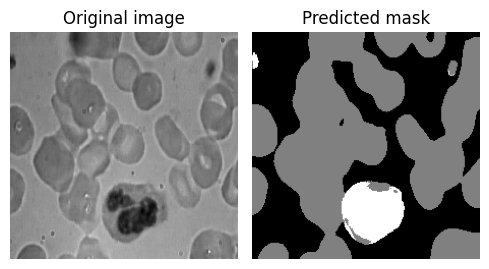

In [ ]:
_mask = model(im)
# Заберем канал который имеет наивысшую вероятность
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], \
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=2,titles=['Original image', \
          'Predicted mask'])

In [ ]:

np.unique(np.array(_mask))

array([0, 1, 2])

Теперь нам необходимо воссоздать архитектуру сети для того чтобы обучиться на нашем датасете:

Для того, чтобы облегчить нам работу с построением архитектуры, создадим два отдельных блока, один из которых будет отвечать за операции в левой части U-Net архитектуры (то есть сжатие изображение), а другой будет отвечать за операции в правой части архитектуры (то есть апсемплинг):

In [ ]:
# сверточный блок для левой части архитектуры

def convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

In [ ]:
# апсемплинг блок для правой части архитектуры

def up_convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace = True)
    )

In [ ]:
# Теперь определим всю архитектуру для U-Net:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=4):
        super().__init__()
        # Будем использовать модель VGG-16 в качестве энкодера
        self.encoder = vgg16_bn(pretrained=pretrained).features
        # Разделим VGG поблочно на отдельные блоки чтобы было удобно их модифицировать и обращаться к ним
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Боттлнек нашей архитектуры (самый глубокий уровень сети -> смотри архитектуру U-Net на картинке выше)
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = convolve(512, 1024)

        # Блоки декодера с "транспонированными свертками" и сверточными блоками
        self.up_conv6 = up_convolve(1024, 512)
        self.conv6 = convolve(512 + 512, 512)
        self.up_conv7 = up_convolve(512, 256)
        self.conv7 = convolve(256 + 512, 256)
        self.up_conv8 = up_convolve(256, 128)
        self.conv8 = convolve(128 + 256, 128)
        self.up_conv9 = up_convolve(128, 64)
        self.conv9 = convolve(64 + 128, 64)
        self.up_conv10 = up_convolve(64, 32)
        self.conv10 = convolve(32 + 64, 32)
        # Финальный сверточный слой для приведения к нужному числу каналов
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Проход через блоки энкодера
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        # Проход через блок боттлнека
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        # Проход через блоки декодера с использованием "skip connections"
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        # Проход через финальный свёрточный слой
        x = self.conv11(x)

        return x

Определим функцию потерь

In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


Функции для тренировки на батче данных и расчет метрик для валидациии:

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

Этап тренировки:

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer,criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss,trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss,val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  val_acc: 0.936  trn_acc: 0.790  val_loss: 1.098  trn_loss: 0.825  (150.57s - 1355.09s remaining)
EPOCH: 2.000  val_acc: 0.929  trn_acc: 0.921  val_loss: 0.622  trn_loss: 0.512  (268.19s - 1072.75s remaining)
EPOCH: 3.000  val_acc: 0.938  trn_acc: 0.925  val_loss: 0.498  trn_loss: 0.429  (386.40s - 901.59s remaining)
EPOCH: 4.000  val_acc: 0.951  trn_acc: 0.925  val_loss: 0.355  trn_loss: 0.377  (503.55s - 755.32s remaining)
EPOCH: 5.000  val_acc: 0.945  trn_acc: 0.953  val_loss: 0.278  trn_loss: 0.275  (626.02s - 626.02s remaining)
EPOCH: 6.000  val_acc: 0.949  trn_acc: 0.904  val_loss: 0.246  trn_loss: 0.371  (744.51s - 496.34s remaining)
EPOCH: 7.000  val_acc: 0.951  trn_acc: 0.929  val_loss: 0.223  trn_loss: 0.288  (861.75s - 369.32s remaining)
EPOCH: 8.000  val_acc: 0.955  trn_acc: 0.932  val_loss: 0.209  trn_loss: 0.271  (978.47s - 244.62s remaining)
EPOCH: 9.000  val_acc: 0.954  trn_acc: 0.933  val_loss: 0.196  trn_loss: 0.252  (1094.84s - 121.65s remaining)
EPOCH: 

100%|██████████| 111/111 [00:00<00:00, 14736.42it/s]


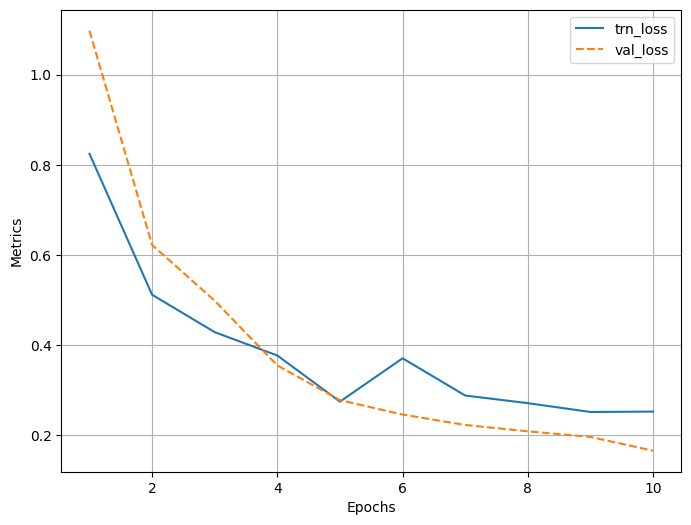

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

Сохраним модель

In [ ]:

import dill

# Assuming you have your model defined as 'model' and the file path for saving as 'model_path'
with open('/content/segmentation_model1.pth', 'wb') as f:
    dill.dump(model, f)

In [ ]:
from google.colab import files
files.download("segmentation_model1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model, '/content/segmentation_model.pth')
# model = torch.load('/content/segment_model.pth')

Протестируем модель:

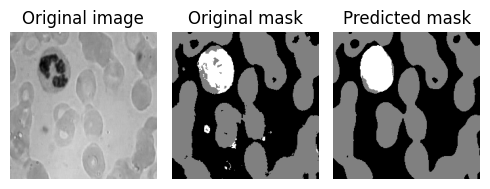

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

In [ ]:
TEST_ds = SegData('TEST')
TEST_dl = DataLoader(TEST_ds, batch_size=1,collate_fn=TEST_ds.collate_fn)

In [ ]:
TEST_ds = SegData('TEST')
TEST_dl = DataLoader(TEST_ds, batch_size=1,collate_fn=TEST_ds.collate_fn)
im, _ = next(iter(TEST_dl))
_mask = model(im)
# Заберем канал который имеет наивысшую вероятность
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], \
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=2,titles=['Original image', \
          'Predicted mask'])

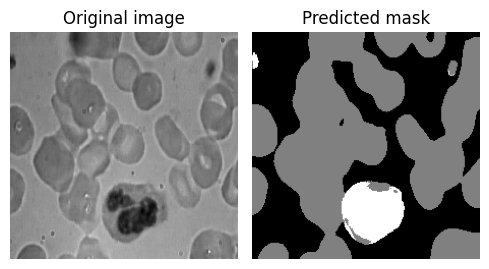

In [ ]:
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], \
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=2,titles=['Original image', \
          'Predicted mask'])

мы можем успешно генерировать маску сегментации с помощью архитектуры U-Net.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mask_on_image(input_image, predicted_mask):
    # Convert the predicted mask to a multi-colored mask
    predicted_mask = predicted_mask.permute(1,2,0).detach().cpu()[:,:,0]
    palette = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0]])  # Specify the colors for each class
    colored_mask = palette[predicted_mask]

    # Get the input image dimensions
    height, width = input_image.shape[:2]

    # Only handle the case when the input image has a shape of (1, H, W, C)
    if input_image.shape[0] == 1:
        input_image = input_image[0, :, :, :]  # Remove the batch dimension

    # # Resize the input image and colored mask to the original dimensions
    input_image = cv2.resize(input_image, (width, height))
    colored_mask = cv2.resize(colored_mask, (width, height))

    # Blend the input image and colored mask using alpha blending
    alpha = 0.5  # Adjust the transparency of the overlay
    overlaid_image = alpha * colored_mask + (1 - alpha) * input_image
    overlaid_image = overlaid_image.astype(np.uint8)

    # Plot the overlaid image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(overlaid_image)
    plt.axis('off')
    plt.show()


In [ ]:
image = cv2.imread('/content/drive/MyDrive/segment/images_prepped_TEST/BloodImage_00108.jpg')
image = cv2.resize(image, (224, 224))

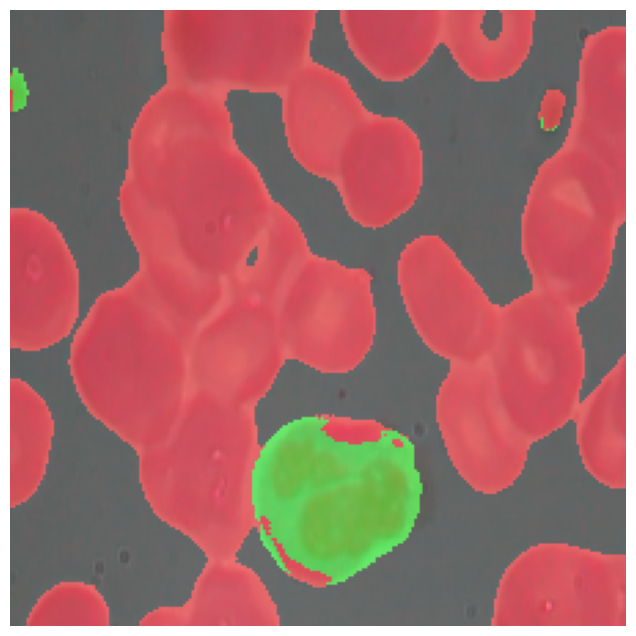

In [ ]:
mask_on_image(image, _mask)

In [ ]:
# torch.save(model, '/content/segment_model.pth')
model = torch.load('/content/segment_model.pth')

In [ ]:
_mask = model(im)